## Introduction

### In this notebook we use [PointNet](https://arxiv.org/abs/1612.00593) to perform 3D Object Classification on [ModelNet10 Dataset](http://modelnet.cs.princeton.edu/#).

<h3><center>Applications of PointNet</center></h3>
<img src="http://stanford.edu/~rqi/pointnet/images/teaser.jpg" width="600" height="500"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/pdf/1612.00593.pdf">Source: PointNet [Charles R. Qi et. al.]</a></center></h4>

## Acknowledgements

### This work was inspired by and borrows code from [Nikita Karaev's](https://github.com/nikitakaraevv) [PointNet implementation](https://github.com/nikitakaraevv/pointnet). 

### Libraries 📚⬇

In [4]:
import os
import numpy as np
import itertools
import math, random
random.seed(42)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from datetime import datetime

from path import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
path = Path("../input/modelnet10-princeton-3d-object-dataset/ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)] # 列出所有子目录
classes = {folder: i for i, folder in enumerate(folders)}; # 创建类别索引映射
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Utility Functions

In [6]:
def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [7]:
with open(path/"sofa/train/sofa_0001.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)

26462

In [8]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='yellowgreen', opacity=0.50, i=i,j=j,k=k)]).show()

In [9]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

In [10]:
pcshow(x,y,z)

# 按照面积加权的方式随机采样点

In [11]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    '''
        使用海伦公式计算给定三角形的面积
    '''
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    '''
    此方法基于三角形的重心坐标来采样一个点
    https://mathworld.wolfram.com/BarycentricCoordinates.html
    '''
    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [12]:
pointcloud = PointSampler(512)((verts, faces))
pcshow(*pointcloud.T)

# 规范化

+ **中心化（Zero-centering）:**

 + 从每个坐标（x, y, z）中减去其平均值，使得点云数据的中心移至原点（0, 0, 0）。这一步是通过计算所有点的均值（沿着每一列）并从每个点中减去这些均值来实现的。

+ **缩放（Scaling）:**

 + 接着，通过计算每个点到原点的欧氏距离（即点的范数），找出这些距离中的最大值。
将点云中的每个点坐标除以这个最大距离，从而将点云的尺度归一化到最大半径为1的球体内。这保证了无论原始点云的尺寸或分布如何，规范化后的点云都将被限制在这个标准化的范围内。

In [13]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [14]:
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

# 数据增强
+ 对点云数据进行随机的Z轴旋转
+ 在点云数据中添加随机噪声

In [15]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [16]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
pcshow(*noisy_rot_pointcloud.T)

In [17]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [18]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

### Define Datasets / Dataloaders

In [19]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms(), voxelize=False, grid_size=1024):
        self.root_dir = root_dir
        all_folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        folders = all_folders[:3] 
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.grid_size = grid_size
        self.files = []
        self.isVoxelize = voxelize
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return self.voxelize(pointcloud) if self.isVoxelize else pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}
    
    def voxelize(self, verts):
        voxel_grid = np.zeros((1, self.grid_size, self.grid_size, self.grid_size))
        # Normalize and scale vertices
        verts -= verts.min(axis=0).values
        verts /= (verts.max(axis=0).values - verts.min(axis=0).values)
        indices = (verts * (self.grid_size - 1)).int()

        # Update the voxel grid
        for idx in range(indices.shape[0]):
            x, y, z = indices[idx][0], indices[idx][1], indices[idx][2]
            voxel_grid[0, x, y, z] = 1
        return voxel_grid

In [20]:
train_transforms = transforms.Compose([
                    PointSampler(512),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

# 绘制混淆矩阵

In [21]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3D CNN (Pytorch)

## Load data and voxelize

In [46]:
grid_size = 16
cnn_train_ds = PointCloudData(path, transform=train_transforms, voxelize=True, grid_size=grid_size)
cnn_valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms, voxelize=True, grid_size=grid_size)

In [47]:
cnn_inv_classes = {i: cat for cat, i in cnn_train_ds.classes.items()};
cnn_inv_classes

{0: 'bathtub', 1: 'bed', 2: 'chair'}

In [48]:
print('Train dataset size: ', len(cnn_train_ds))
print('Valid dataset size: ', len(cnn_valid_ds))
print('Number of classes: ', len(cnn_train_ds.classes))
print('Sample pointcloud shape: ', cnn_train_ds[0]['pointcloud'].shape)
print('Class: ', cnn_inv_classes[cnn_train_ds[0]['category']])

Train dataset size:  1510
Valid dataset size:  250
Number of classes:  3
Sample pointcloud shape:  (1, 16, 16, 16)
Class:  bathtub


In [49]:
sample = cnn_train_ds[0]['pointcloud']

# Print the type and check for the 'size' method or attribute
print("Type of sample['pointcloud']:", type(sample))
print("Sample pointcloud content:", sample)
print(sample.shape)

Type of sample['pointcloud']: <class 'numpy.ndarray'>
Sample pointcloud content: [[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 1. 0. ... 1. 1. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 1. 1. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 1. 1. 0.]
   [0. 0. 0. ... 0. 1. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 1. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 1. 0. ... 0. 0. 0.]
   

In [50]:
cnn_train_loader = DataLoader(dataset=cnn_train_ds, batch_size=32, shuffle=True, num_workers=4)
cnn_valid_loader = DataLoader(dataset=cnn_valid_ds, batch_size=64, num_workers=4)

## Define model

In [51]:
class CNN3D(nn.Module):
    def __init__(self, num_classes, grid_size):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        reduced_size = grid_size // 8  # Assuming three max-pooling layers
        self.fc1 = nn.Linear(128 * reduced_size**3, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn3d = CNN3D(num_classes=len(cnn_train_ds.classes), grid_size=grid_size).to(device)  # 确保模型的类别数和网格大小正确
if torch.cuda.is_available():
    cnn3d = cnn3d.cuda()  # Move model to GPU if available
    cnn3d = nn.DataParallel(cnn3d)  # Wrap model for multi-GPU if more than one GPU is available
cnn_criterion = nn.CrossEntropyLoss()  # 交叉熵损失通常用于多分类问题
cnn_optimizer = torch.optim.Adam(cnn3d.parameters(), lr=0.001)  # 使用Adam优化器
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from datetime import datetime


def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, accumulation_steps=4):
    scaler = GradScaler()  # 初始化梯度缩放器
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()  # 初始化梯度
        print (f'-----{datetime.now()}------')
        for i, data in enumerate(train_loader):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
#             print(f'-------{i}  {datetime.now()}------')
            with autocast():  # 启用自动混合精度
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps  # 调整损失以反映梯度累积的效果

            scaler.scale(loss).backward()  # 反向传播时应用梯度缩放

            if (i + 1) % accumulation_steps == 0:  # 每 accumulation_steps 步更新一次参数
                scaler.step(optimizer)  # 更新优化器
                scaler.update()  # 更新缩放器
                optimizer.zero_grad()  # 清除梯度

            running_loss += loss.item() * accumulation_steps  # 累积调整后的损失

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

        # 验证阶段
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data in valid_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                with autocast():  # 同样在验证过程中使用自动混合精度
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f'Accuracy on validation set: {100 * correct / total}%')

In [53]:
print(device)

cuda


## Train

In [54]:
# 调用训练函数
train_model(cnn3d, cnn_train_loader, cnn_valid_loader, cnn_criterion, cnn_optimizer, num_epochs=10)

-----2024-07-29 09:09:33.640492------
Epoch 1/10, Loss: 0.9715910640855631
Accuracy on validation set: 51.6%
-----2024-07-29 09:16:02.987066------
Epoch 2/10, Loss: 0.8215552158653736
Accuracy on validation set: 52.4%
-----2024-07-29 09:22:42.329349------
Epoch 3/10, Loss: 0.648540111258626
Accuracy on validation set: 57.2%
-----2024-07-29 09:29:12.252039------
Epoch 4/10, Loss: 0.48885689831028384
Accuracy on validation set: 68.4%
-----2024-07-29 09:35:49.446003------
Epoch 5/10, Loss: 0.33259966612483066
Accuracy on validation set: 78.8%
-----2024-07-29 09:42:16.366308------
Epoch 6/10, Loss: 0.2629408575594425
Accuracy on validation set: 77.2%
-----2024-07-29 09:48:18.549218------
Epoch 7/10, Loss: 0.21877257021454474
Accuracy on validation set: 83.6%
-----2024-07-29 09:54:16.555028------
Epoch 8/10, Loss: 0.16655287542380393
Accuracy on validation set: 83.6%
-----2024-07-29 10:00:31.560430------
Epoch 9/10, Loss: 0.1535031016295155
Accuracy on validation set: 87.6%
-----2024-07-29 

## Evaluate

In [55]:
cnn3d.eval()
cnn_all_preds = []
cnn_all_labels = []
with torch.no_grad():
    for i, data in enumerate(cnn_valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(cnn_valid_loader)))
        
        inputs, labels = data['pointcloud'].float().to(device), data['category'].to(device)
        outputs = cnn3d(inputs)
        _, preds = torch.max(outputs.data, 1)
        cnn_all_preds += list(preds.cpu().numpy())
        cnn_all_labels += list(labels.cpu().numpy())

Batch [   1 /    4]
Batch [   2 /    4]
Batch [   3 /    4]
Batch [   4 /    4]


In [56]:
cnn_cm = confusion_matrix(cnn_all_labels, cnn_all_preds)

Normalized confusion matrix


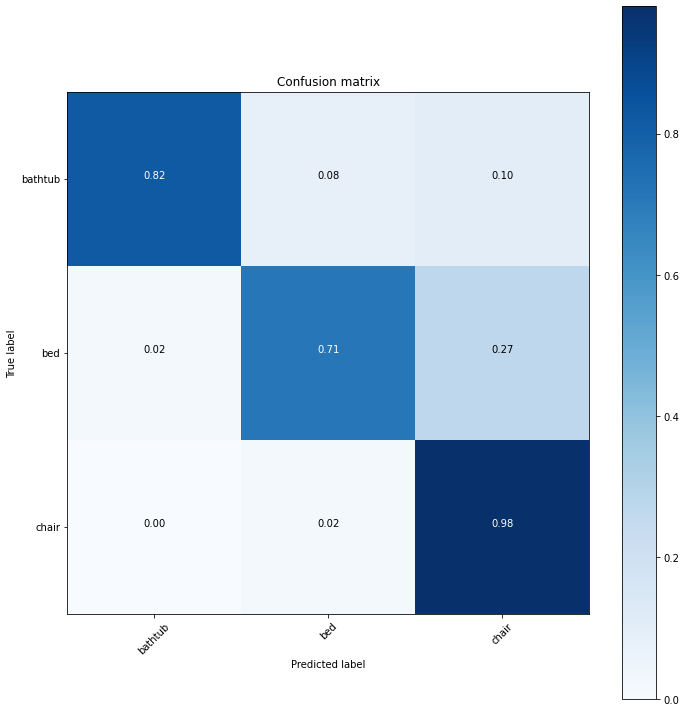

In [57]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnn_cm, list(cnn_inv_classes.values()), normalize=True)

# PointNet

<h3><center>PointNet Model Architecture</center></h3>
<img src="http://stanford.edu/~rqi/pointnet/images/pointnet.jpg" width="750" height="750"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/pdf/1612.00593.pdf">Source: PointNet [Charles R. Qi et. al.]</a></center></h4>

## Load Original Point Cloud

In [22]:
pn_train_ds = PointCloudData(path, transform=train_transforms)
pn_valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [23]:
pn_inv_classes = {i: cat for cat, i in pn_train_ds.classes.items()};
pn_inv_classes

{0: 'bathtub', 1: 'bed', 2: 'chair'}

In [24]:
print('Train dataset size: ', len(pn_train_ds))
print('Valid dataset size: ', len(pn_valid_ds))
print('Number of classes: ', len(pn_train_ds.classes))
print('Sample pointcloud shape: ', pn_train_ds[0]['pointcloud'].size())
print('Class: ', pn_inv_classes[pn_train_ds[0]['category']])

Train dataset size:  1510
Valid dataset size:  250
Number of classes:  3
Sample pointcloud shape:  torch.Size([512, 3])
Class:  bathtub


In [25]:
pn_train_loader = DataLoader(dataset=pn_train_ds, batch_size=32, shuffle=True, num_workers=4)
pn_valid_loader = DataLoader(dataset=pn_valid_ds, batch_size=64, num_workers=4)

## Define PointNet

In [26]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

## PointNet self-defined loss
分类损失（NLLLoss）：

使用torch.nn.NLLLoss()，这是一个负对数似然损失，常用于多分类问题中。它要求模型的输出（outputs）是对数概率形式，通常与LogSoftmax层结合使用。
正交性正则化项：

正则化项中使用了两个正交性约束，分别对应m3x3和m64x64这两个矩阵。这些矩阵通常来自PointNet中的T-Net（transform network），用于对点云进行空间变换。
id3x3和id64x64是单位矩阵，它们在每个batch的每个样本上都被复制一遍。
diff3x3计算了m3x3与其转置的乘积与单位矩阵之间的差，目的是使m3x3接近正交矩阵。正交矩阵的特点是其与自身的转置乘积等于单位矩阵。
diff64x64类似地计算了m64x64。
整体损失计算：

总损失是分类损失和正则化项的加权和。其中，alpha是一个超参数，用于控制正则化项的权重。
正则化项通过计算diff3x3和diff64x64的Frobenius范数（即矩阵元素平方和的平方根）来衡量两个变换矩阵与正交矩阵的偏差。
正则化项被平均到每个样本上，这通过除以批次大小bs实现。

In [27]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
pointnet = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
if os.path.exists('../input/pointnet-for-3d-object-classification-ii-pytorch/save.pth'):
    pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-ii-pytorch/save.pth'))
    print('Loaded Pre-trained PointNet Model!')

In [30]:
pn_optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0008)

## Train PointNet

In [31]:
def pn_train(model, train_loader, val_loader=None,  epochs=2):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        print(datetime.now())
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            pn_optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            pn_optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 5 == 4:    # print every 5 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 5))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        torch.save(pointnet.state_dict(), "save.pth")

In [32]:
pn_train(pointnet, pn_train_loader, pn_valid_loader, epochs=10)

2024-07-29 11:36:49.487099
[Epoch: 1, Batch:    5 /   48], loss: 3.140
[Epoch: 1, Batch:   10 /   48], loss: 1.643
[Epoch: 1, Batch:   15 /   48], loss: 1.071
[Epoch: 1, Batch:   20 /   48], loss: 0.548
[Epoch: 1, Batch:   25 /   48], loss: 0.420
[Epoch: 1, Batch:   30 /   48], loss: 0.239
[Epoch: 1, Batch:   35 /   48], loss: 0.469
[Epoch: 1, Batch:   40 /   48], loss: 0.518
[Epoch: 1, Batch:   45 /   48], loss: 0.260
Valid accuracy: 79 %
2024-07-29 11:42:56.422438
[Epoch: 2, Batch:    5 /   48], loss: 0.269
[Epoch: 2, Batch:   10 /   48], loss: 0.213
[Epoch: 2, Batch:   15 /   48], loss: 0.173
[Epoch: 2, Batch:   20 /   48], loss: 0.131
[Epoch: 2, Batch:   25 /   48], loss: 0.178
[Epoch: 2, Batch:   30 /   48], loss: 0.159
[Epoch: 2, Batch:   35 /   48], loss: 0.208
[Epoch: 2, Batch:   40 /   48], loss: 0.141
[Epoch: 2, Batch:   45 /   48], loss: 0.201
Valid accuracy: 90 %
2024-07-29 11:48:55.604558
[Epoch: 3, Batch:    5 /   48], loss: 0.168
[Epoch: 3, Batch:   10 /   48], loss: 0.1

## Evaluate PointNet

In [33]:
pointnet.eval()
pn_all_preds = []
pn_all_labels = []
with torch.no_grad():
    for i, data in enumerate(pn_valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(pn_valid_loader)))
        
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        pn_all_preds += list(preds.cpu().numpy())
        pn_all_labels += list(labels.cpu().numpy())

Batch [   1 /    4]
Batch [   2 /    4]
Batch [   3 /    4]
Batch [   4 /    4]


In [34]:
pn_cm = confusion_matrix(pn_all_labels, pn_all_preds)

Confusion matrix, without normalization


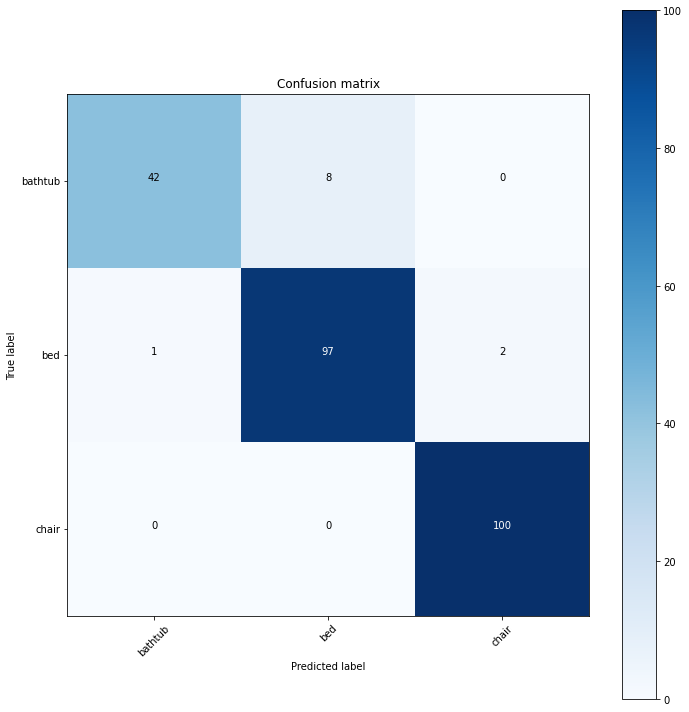

In [35]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pn_cm, list(pn_inv_classes.values()), normalize=False)

# PointNet ++

## Load Point Cloud data (Same as PointNet)

In [33]:
pnpp_train_ds = PointCloudData(path, transform=train_transforms)
pnpp_valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [34]:
pnpp_inv_classes = {i: cat for cat, i in pnpp_train_ds.classes.items()};
pnpp_inv_classes

{0: 'bathtub', 1: 'bed', 2: 'chair'}

In [35]:
print('Train dataset size: ', len(pnpp_train_ds))
print('Valid dataset size: ', len(pnpp_valid_ds))
print('Number of classes: ', len(pnpp_train_ds.classes))
print('Sample pointcloud shape: ', pnpp_train_ds[0]['pointcloud'].size())
print('Class: ', pnpp_inv_classes[pnpp_train_ds[0]['category']])

Train dataset size:  1510
Valid dataset size:  250
Number of classes:  3
Sample pointcloud shape:  torch.Size([512, 3])
Class:  bathtub


In [36]:
pnpp_train_loader = DataLoader(dataset=pnpp_train_ds, batch_size=32, shuffle=True, num_workers=4)
pnpp_valid_loader = DataLoader(dataset=pnpp_valid_ds, batch_size=64, num_workers=4)

## Helper functions

In [37]:
def furthest_point_sampling(points, K):
    device = points.device
    B, _, N = points.size()
    centroids = torch.zeros(B, K, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)

    for i in range(K):
        centroids[:, i] = farthest
#         print("Batch indices shape:", batch_indices.shape)  # Should be [B]
#         print("Farthest shape:", farthest.shape)  # Should be [B]
        centroid = points[batch_indices, :, farthest].unsqueeze(-1)  # Add dimension without view
#         print("Centroid shape:", centroid.shape)  # Check shape
        dist = torch.sum((points - centroid) ** 2, 1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def get_neighborhood(points, centroids_idx, radius):
    B, C, N = points.size()
    K = centroids_idx.size(1)
    centroids = points.gather(2, centroids_idx.unsqueeze(1).expand(-1, C, -1))
    
    # Expand points and centroids for vectorized distance calculation
    points_expanded = points.unsqueeze(2).expand(B, C, K, N)  # Shape [B, C, K, N]
    centroids_expanded = centroids.unsqueeze(3).expand(B, C, K, N)  # Shape [B, C, K, N]
    
    # Compute distances
    dists = torch.sum((points_expanded - centroids_expanded) ** 2, dim=1)  # Sum over the channel dimension
    mask = (dists < radius ** 2).float()  # Shape [B, K, N]
    return mask


def sample_and_group(num_centroids, radius, x):
    centroids_idx = furthest_point_sampling(x, num_centroids)
    group_mask = get_neighborhood(x, centroids_idx, radius)
    x = x.unsqueeze(2).expand(-1, -1, num_centroids, -1) * group_mask.unsqueeze(1)
    group_features = torch.mean(x, 3)  # Using mean pooling
    return group_features

class PointNetSetAbstraction(nn.Module):
    def __init__(self, num_points, radius, in_channels, mlp_layers):
        super(PointNetSetAbstraction, self).__init__()
        self.num_points = num_points
        self.radius = radius
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channels = in_channels
        for out_channels in mlp_layers:
            self.mlp_convs.append(nn.Conv1d(last_channels, out_channels, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channels))
            last_channels = out_channels

    def forward(self, x):
        group_features = sample_and_group(self.num_points, self.radius, x)
        for i, conv in enumerate(self.mlp_convs):
            group_features = F.relu(self.mlp_bns[i](conv(group_features)))
        return group_features

In [38]:
# Example Usage
points = torch.rand(32, 3, 512)  # Random 3D points, [batch_size, num_features, num_points]
sa_layer = PointNetSetAbstraction(num_points=128, radius=0.2, in_channels=3, mlp_layers=[64, 64, 128])
features = sa_layer(points)
print(features.shape)

torch.Size([32, 128, 128])


## Define PointNet++

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetPlusPlus(nn.Module):
    def __init__(self, num_classes):
        super(PointNetPlusPlus, self).__init__()
        self.sa1 = PointNetSetAbstraction(num_points=128, radius=0.1, in_channels=3, mlp_layers=[64, 64, 128])
        self.sa2 = PointNetSetAbstraction(num_points=32, radius=0.2, in_channels=128, mlp_layers=[128, 128, 256])
        self.sa3 = PointNetSetAbstraction(num_points=8, radius=0.4, in_channels=256, mlp_layers=[256, 256, 512])

        # Global feature pooling
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # Classification layers
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Set Abstraction layers
        x = self.sa1(x)
        x = self.sa2(x)
        x = self.sa3(x)

        # Global feature pooling
        x = self.global_pool(x).squeeze(-1)

        # Fully connected layers for classification
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [40]:
points = torch.rand(32, 3, 512)  # Random 3D points, [batch_size, num_features, num_points]
model = PointNetPlusPlus(num_classes=3)
output = model(points)
print(output.size())  # Output should be [32, 3] for batch size of 32 and 3 classes

torch.Size([32, 3])


In [41]:
def pnpp_train(model, train_loader, optimizer, loss_function, epochs=2, val_loader=None, device='cuda'):
    model.to(device)
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        print(datetime.now())
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1,2))  # Assuming the output is directly from model

            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 5 == 4:  # print every 5 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 5))
                running_loss = 0.0

        if val_loader:
            val_acc = pnpp_evaluate(model, val_loader, device)
            print('Validation accuracy: %d %%' % val_acc)

        # Save the model
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

def pnpp_evaluate(model, loader, device='cuda'):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            outputs = model(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def pnpp_predict(model, loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            print('Batch [%4d / %4d]' % (i+1, len(loader)))
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            outputs = model(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

## Train PointNet++

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pointnet_plus_plus = PointNetPlusPlus(3).to(device)

# 定义损失函数和优化器
pnpp_criterion = nn.NLLLoss()
pnpp_optimizer = torch.optim.Adam(pointnet_plus_plus.parameters(), lr=0.0008)
# 训练和验证循环
num_epochs = 10
pnpp_train(pointnet_plus_plus, pnpp_train_loader, pnpp_optimizer, pnpp_criterion, num_epochs, pnpp_valid_loader, device)

2024-07-29 08:05:14.428377
[Epoch: 1, Batch:    5 /   48], loss: 1.035
[Epoch: 1, Batch:   10 /   48], loss: 0.719
[Epoch: 1, Batch:   15 /   48], loss: 0.542
[Epoch: 1, Batch:   20 /   48], loss: 0.472
[Epoch: 1, Batch:   25 /   48], loss: 0.350
[Epoch: 1, Batch:   30 /   48], loss: 0.366
[Epoch: 1, Batch:   35 /   48], loss: 0.255
[Epoch: 1, Batch:   40 /   48], loss: 0.246
[Epoch: 1, Batch:   45 /   48], loss: 0.271
Validation accuracy: 40 %
2024-07-29 08:11:39.029275
[Epoch: 2, Batch:    5 /   48], loss: 0.329
[Epoch: 2, Batch:   10 /   48], loss: 0.288
[Epoch: 2, Batch:   15 /   48], loss: 0.331
[Epoch: 2, Batch:   20 /   48], loss: 0.275
[Epoch: 2, Batch:   25 /   48], loss: 0.343
[Epoch: 2, Batch:   30 /   48], loss: 0.311
[Epoch: 2, Batch:   35 /   48], loss: 0.337
[Epoch: 2, Batch:   40 /   48], loss: 0.297
[Epoch: 2, Batch:   45 /   48], loss: 0.196
Validation accuracy: 61 %
2024-07-29 08:18:19.984254
[Epoch: 3, Batch:    5 /   48], loss: 0.265
[Epoch: 3, Batch:   10 /   48],

## Evaluate PointNet++

In [43]:
pnpp_all_labels, pnpp_all_preds = pnpp_predict(pointnet_plus_plus, pnpp_valid_loader, device)

Batch [   1 /    4]
Batch [   2 /    4]
Batch [   3 /    4]
Batch [   4 /    4]


In [44]:
pnpp_cm = confusion_matrix(pnpp_all_labels, pnpp_all_preds)

Confusion matrix, without normalization


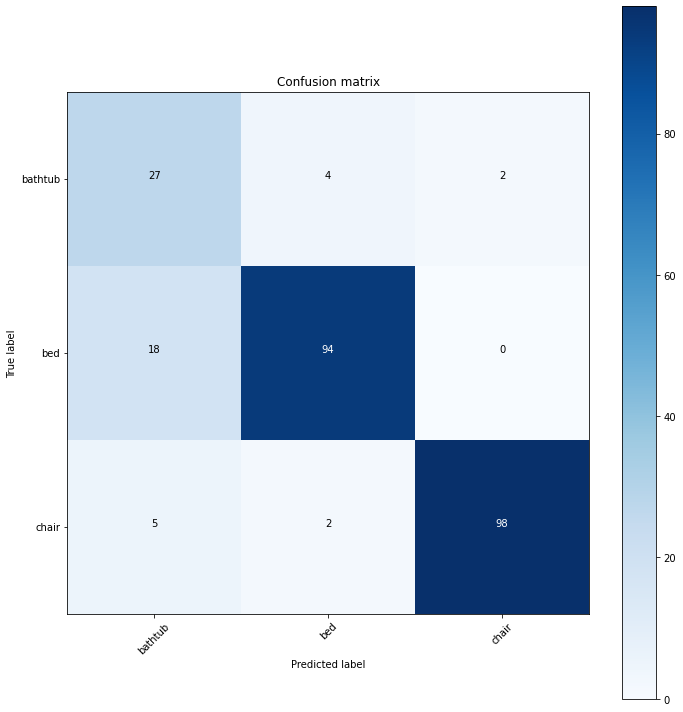

In [45]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pnpp_cm, list(pnpp_inv_classes.values()), normalize=False)

# References
+ https://github.com/yanx27/Pointnet_Pointnet2_pytorch/tree/master
+ 